# CSO QaQc: Conclusions and Analysis

Here I will go over findings and insights from my QaQc of the data across multiple notebooks. I will take time to talk about and show my findings. This notebook will also be a place for me to conduct some statistical tests on the data so we can make quantitative conclusions on parts of the data.

* NOTE: Go back and update visualizations of the data using seaborn

In [1]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import seaborn as sns

# Import necessary packages, may need more or less as I go.

In [2]:
CSO_gdf = gpd.read_file('CSOgeodata.geojson')
CSO_gdf['timestamp'] = pd.to_datetime(CSO_gdf.timestamp)
CSO_gdf['flags'] = False
CSO_gdf.head(10)

,id,author,depth,source,timestamp,elevation,geometry,flags
0,4J5z5w7h,camila chamizo,150.0,SnowPilot,2021-06-28 20:15:00+00:00,1881.618530,POINT (-71.56655 -41.10209),False
1,2C8R7ehK,camila chamizo,150.0,SnowPilot,2021-06-28 18:15:00+00:00,1881.618530,POINT (-71.56655 -41.10209),False
2,a3a3VCXY,juan manuel raselli,155.0,SnowPilot,2021-06-26 20:00:00+00:00,1577.167603,POINT (-72.93703 -49.07451),False
3,ImH60r2U,John Soltys,90.0,MountainHub,2021-06-26 15:12:30.931999+00:00,1585.094727,POINT (-121.40983 47.45218),False
4,mebZPRGY,Roberto indio Treu,400.0,SnowPilot,2021-06-25 15:00:00+00:00,1568.316284,POINT (-72.93789 -49.07159),False
5,es0SceGk,juan manuel raselli,135.0,SnowPilot,2021-06-24 22:00:00+00:00,1310.907715,POINT (-72.92399 -49.07053),False
6,cDke3Yv1,David Lundin,47.0,SnowPilot,2021-06-23 17:00:00+00:00,1844.694214,POINT (168.93805 -44.85328),False
7,h5jx/c96,David Lundin,55.0,SnowPilot,2021-06-23 17:00:00+00:00,1836.381592,POINT (168.94681 -44.85560),False
8,3BIc0jAn,George Loomes,120.0,SnowPilot,2021-06-23 00:30:00+00:00,1894.013428,POINT (170.33054 -43.73712),False
9,nb5UvScN,John Soltys,130.0,MountainHub,2021-06-20 17:21:45.983002+00:00,1822.853027,POINT (-121.50287 46.86515),False


# Data from MountainHub

We'll be looking into values specific to `MountianHub` as those are the most likely to have some form of QaQc failure due to the self reporting nature of it. `SnowPilot` is much more rigorous in its data collection.

I'll be analyizing and comparing `MountainHub` through 3 different lenses:

* General Distribution of the `MountainHub` data and how it compares to all the data and specific sources.

* Small depth values close to `0 cm`. Zero values are interesting values to look at in the data as it appears quite often in many different areas and has a sizeable influence on an areas over all snow quality and depth. We have a discrepnacy with these values in `SnowPilot` so it will be interesting to see where `MountainHub` stands.

* Large depth values over `240 cm`. This is the theoretical maximum for most recreational skiers due to snow probe constraints so I would like to see how this compares to the other sources and data as a whole.

At the end of this notebook I'll provide some form of roadmap on a possible quality checks we could assign to the database to flag specific values that may be erronious or at the very least suspicious. These quality checks will have to catered to the specific source as `MountainHub` and `SnowPilot` have their own share of quircks and possible issues.

# General Distributions

I'll be constructing a few plots for qualitative assessments of the data and than doing statistics on `MountainHub` with respect to the rest of the data. This will help preface a lot of what we've been working on in multiple notebooks and what we'll be highlighting in this notebook.

### Database statistics

In [3]:
CSO_gdf.describe()

,depth,elevation
count,30497.000000,30497.000000
mean,105.028916,1209.759659
std,86.295661,966.930380
min,0.000000,0.000000
25%,40.000000,483.760162
50%,94.000000,907.063049
75%,150.000000,1861.142090
max,1176.000000,4614.939453


### MountainHub statistics

In [4]:
CSO_MH = CSO_gdf.loc[CSO_gdf['source'] == "MountainHub"]
CSO_MH.describe()

,depth,elevation
count,4663.000000,4663.000000
mean,120.274660,1322.582082
std,99.741173,903.036526
min,0.000000,0.010386
25%,50.000000,569.156372
50%,94.000000,1119.703003
75%,165.000000,2056.575073
max,998.219985,3960.614014


### Visuals of the data

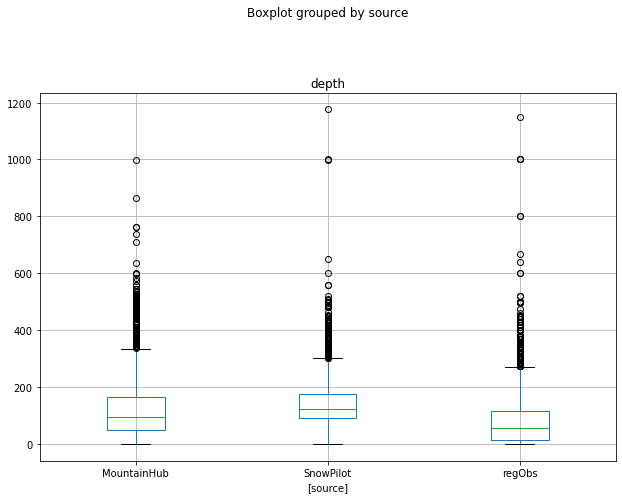

In [5]:
boxplots = CSO_gdf.boxplot(column=['depth'], by=['source'],layout=(2, 1), figsize = (10,15))

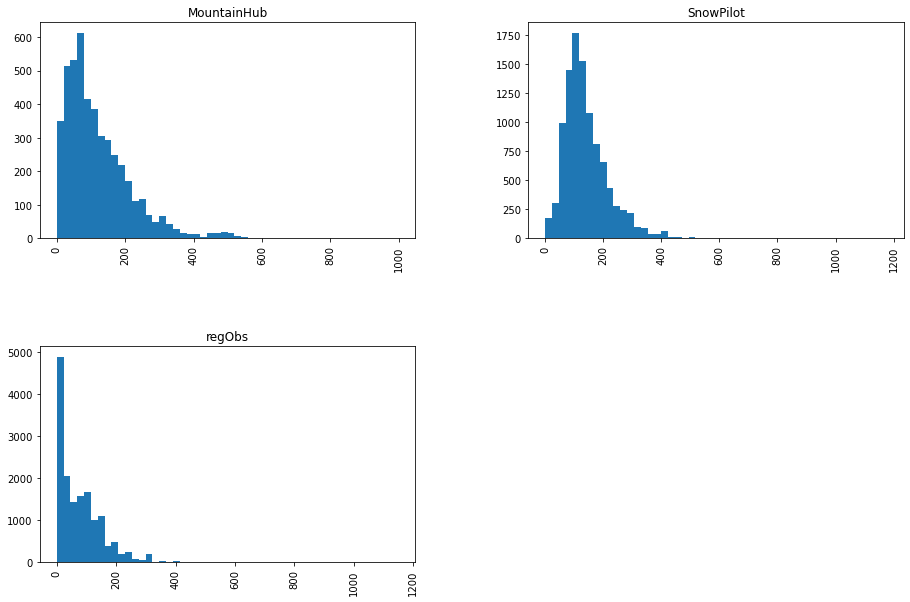

In [6]:
histogram_gdf = CSO_gdf['depth'].hist(by= CSO_gdf['source'], bins = 50, figsize= (15,10))

In [7]:
CSO_gdf[['source', 'depth']].groupby(['source']).agg(['count', 'min', 'max'])

depth                  
             count  min          max
source                              
MountainHub   4663  0.0   998.219985
SnowPilot    10278  0.0  1176.000000
regObs       15556  0.1  1150.000000

We can see from just visual analysis, that `MountainHub` has much more variability than `SnowPilot` which makes a lot of sense. Variability isn't necessarily a bad thing and even in this case it can be a good thing when it comes to having data from a multitude of places and people. I think this sets up the rest of our anaylsis.

# Zero Depth Values

Building off of much of the information in `CSOZeros.ipynb` but now mainly focused on how `MountainHub` compares to the rest of the data. Small depth values are very interesting especially with the inconsistencies revolving around `SnowPilot`. It's a way for us to look at one of the 2 extremes for data collection and to see how the Citizen Science data collection compares to more contained forms of data aquisition. 

In [8]:
ZERO = 0
CSO_MH.loc[CSO_MH['depth'] == ZERO, 'flags'] = True
CSO_MHzeros = CSO_MH.loc[CSO_MH['flags'] == True]
CSO_MHzeros.describe()

/Users/kamrankazemi/opt/miniconda3/envs/cso_obsdata/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,depth,elevation
count,24.0,24.000000
mean,0.0,921.126173
std,0.0,767.990028
min,0.0,4.288624
25%,0.0,395.372711
50%,0.0,792.336456
75%,0.0,1195.424530
max,0.0,3157.386719


In [9]:
CSO_gdf['flags'] = False
CSO_gdf.loc[CSO_gdf['depth'] == ZERO, 'flags'] = True
CSO_gdfzeros = CSO_gdf.loc[CSO_gdf['flags'] == True]
CSO_gdfzeros.describe()

,depth,elevation
count,184.0,184.000000
mean,0.0,1454.691250
std,0.0,938.101238
min,0.0,4.288624
25%,0.0,675.057907
50%,0.0,1191.549316
75%,0.0,2283.689453
max,0.0,3677.466797


### SnowPilot Zero Values

In [10]:
CSO_gdfzeros[['source', 'elevation']].groupby(['source']).agg(['count', 'min', 'max'])

elevation                        
                count        min          max
source                                       
MountainHub        24   4.288624  3157.386719
SnowPilot         160  45.491261  3677.466797

We've discussed the issue with 0's from `SnowPilot` previously and how that may be a database problem or even a miscommunication with the field reporting. Nonetheless there appears to be a discrepancy in the amount of zeros reported by them considering they are digging snow pits, this is something that we're still inquiring about.

### MountainHub Zero Values

In [11]:
CSO_DAVE = CSO_gdf.loc[CSO_gdf['author'] == "David Hill"]
CSO_DAVE

,id,author,depth,source,timestamp,elevation,geometry,flags
109,byeFFRIW,David Hill,160.00,MountainHub,2021-05-11 18:44:14.283000+00:00,2577.653564,POINT (-122.14950 43.52067),False
1611,eWcybA8B,David Hill,280.00,MountainHub,2021-03-13 16:16:21.386000+00:00,2108.131836,POINT (-122.08692 43.14962),False
1612,mZCKCItp,David Hill,225.00,MountainHub,2021-03-13 15:24:32.368999+00:00,1977.794678,POINT (-122.10008 43.14938),False
2251,kljNzl3E,David Hill,170.00,MountainHub,2021-02-28 22:37:50.908001+00:00,2292.394287,POINT (-122.23240 41.36627),False
2310,hVe8P1EP,David Hill,183.00,MountainHub,2021-02-27 22:52:40.257999+00:00,2146.215088,POINT (-122.23967 41.35884),False
...,...,...,...,...,...,...,...,...
21542,7BB+SBZV,David Hill,35.56,MountainHub,2017-11-22 20:00:00+00:00,1530.093140,POINT (-121.88220 44.40199),False
21697,H1fgS9Sa,David Hill,55.88,MountainHub,2017-11-15 20:00:00+00:00,1530.046509,POINT (-121.88218 44.40199),False
21766,2GZ+o/nC,David Hill,46.00,MountainHub,2017-11-08 20:00:00+00:00,1530.113159,POINT (-121.88215 44.40202),False
21832,X9x9gJfK,David Hill,2.54,MountainHub,2017-10-22 19:00:00+00:00,1530.700195,POINT (-121.88225 44.40207),False


In [12]:
CSO_DAVE_zeros = CSO_DAVE.loc[CSO_DAVE['flags'] == True]
CSO_DAVE_zeros

,id,author,depth,source,timestamp,elevation,geometry,flags


Something that is also strange about the 0 values in the database is that some of them seem to be omitted. Dave has said that he has recorded 0 depth values somewhat reguarlary but they don't show up. Even stranger is that we do see 0 values from other team members such as Gabe and Katreen so something seems wrong on the `MountainHub` end.

### How Impactful Are Zero Values?

It somewhat depends on the domain as some of them are much more rich in 0 depth values. For example I'll show a domain in California that is actually considerably altered by 0 depth values. This means that it's very important for us to figure out which ones are intentional or missing in the database.

In [13]:
CSO_CA = gpd.read_file('CSO_CA.geojson')
CSO_CA['timestamp'] = pd.to_datetime(CSO_CA.timestamp)
CSO_CA['flags'] = False
CSO_CA.loc[CSO_CA['depth'] <= ZERO, 'flags'] = True
CSO_noCA = (CSO_CA.loc[CSO_CA['flags'] == False])
CSO_CAzeros = CSO_CA.loc[CSO_CA['flags'] == True]
CSO_CAzeros.describe()

,depth,elevation
count,17.0,17.000000
mean,0.0,2373.670468
std,0.0,134.934852
min,0.0,2168.730469
25%,0.0,2256.924805
50%,0.0,2406.352783
75%,0.0,2427.442383
max,0.0,2637.030518


### California's Mean w/ Zeros

In [14]:
CSO_meanCA = CSO_CA['depth'].mean()
CSO_meanCA

155.31314122126275

### California's Mean w/o Zeros

In [15]:
CSO_noZeroMean = CSO_noCA['depth'].mean()
CSO_noZeroMean

161.9139497231664

We can see that the difference in means is about 6 cm which is not a negligible amount. These are all `SnowPilot` zeros as well so it's unclear whether any of them are intentional.

# Large Depth Values

For large depth values it's important to take into account snow probe limitations for `MountainHub`. They usually cap out recreationally at 300 cm and usually start to become less practical at lengths over 450 cm. So values in `MountainHub` with depths larger than 450 cm are suspicous, especially if they also contain trailing decimals as maybe that suggests an unusual unit conversion. It's also worth noting that the `MountainHub` database has a small bias for depths equal to 300 cm.  

In [16]:
Depth1 = 240
Depth2 = 300

Using our `Depth1` to look at large depth values over 240 cm.

### Large Depth Value Statistics

In [17]:
DELTA = 1
CSO_gdf['flags'] = False
CSO_gdf.loc[CSO_gdf['depth'] > (Depth1 - DELTA), 'flags'] = True
CSO_Large = CSO_gdf.loc[CSO_gdf['flags'] == True]
CSO_Large.describe()

,depth,elevation
count,2280.000000,2280.000000
mean,310.946526,1382.470704
std,84.869530,777.400437
min,239.999991,0.051468
25%,255.000000,781.986267
50%,292.100000,1186.411316
75%,330.200000,1963.574341
max,1176.000000,3973.190674


In [18]:
CSO_Large[['source', 'depth']].groupby(['source']).agg(['count', 'min', 'max'])

depth                         
            count         min          max
source                                    
MountainHub   507  239.999991   998.219985
SnowPilot    1071  240.000000  1176.000000
regObs        702  240.000000  1150.000000

### Visual of the large data

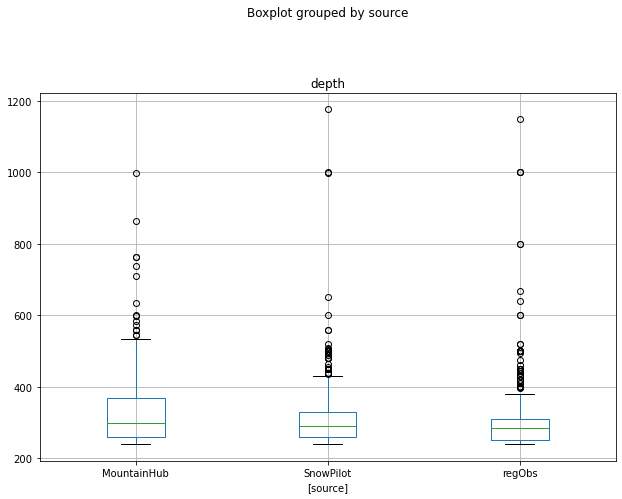

In [19]:
boxplot_Large = CSO_Large.boxplot(column=['depth'], by=['source'],layout=(2, 1), figsize = (10,15))

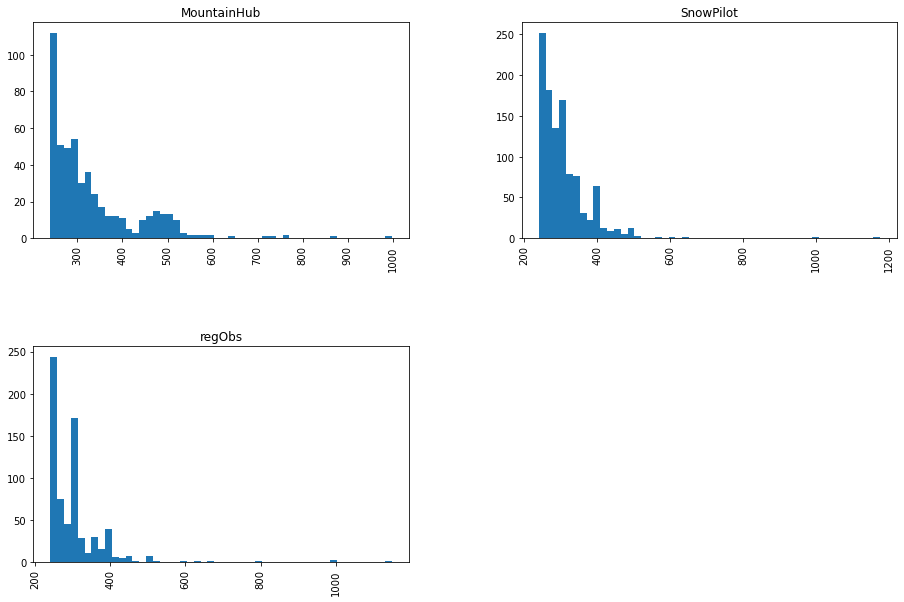

In [20]:
histogram_Large = CSO_Large['depth'].hist(by= CSO_Large['source'], bins = 50, figsize= (15,10))

Visually we can see that there's much more variation in the `MountainHub` data than there is in `SnowPilot`, which we would expect. Interestingly I feel as though this is evidence that much of the measurements over about 550 cm are unreliable. So that is where we'll be looking next. 

### SnowProbe Bias

Using our `Depth2` to test for bias as that is the most common snowprobe length from testing done in `CSOLarge.ipynb`.

In [21]:
CSO_MHLarge = CSO_Large.loc[CSO_Large['source'] == "MountainHub"]
CSO_MHLarge.describe()

,depth,elevation
count,507.000000,507.000000
mean,334.314753,1718.355865
std,101.675658,757.543127
min,239.999991,0.051468
25%,260.000000,1160.861450
50%,300.000000,1920.900635
75%,370.000000,2219.217896
max,998.219985,3689.004150


In [22]:
CSO_MHLarge['flags'] = False
CSO_MHLarge.loc[CSO_MHLarge['depth'] == Depth2, 'flags'] = True
CSO_bias = CSO_MHLarge.loc[CSO_MHLarge['flags'] == True]
CSO_bias.describe()

/Users/kamrankazemi/opt/miniconda3/envs/cso_obsdata/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/kamrankazemi/opt/miniconda3/envs/cso_obsdata/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,depth,elevation
count,29.0,29.000000
mean,300.0,1723.260545
std,0.0,717.041755
min,300.0,36.845131
25%,300.0,1418.756226
50%,300.0,1903.564697
75%,300.0,2143.725830
max,300.0,3371.974365


### MountainHub mode for comparison

In [23]:
CSO_MHLarge.mode()['depth'][0]

250.0

Although there is a bias for depth values of 300 cm it's still not the most common depth value for larger depth values which is interesting. This will require more discussion but if anything it shows that the data isn't heavily constrained by any form of snow probe bias for larger values. 

### Conclusions revolving around Large Depth Values

I believe it's reasonable that we implement a max snow depth value for `MountainHub` as any of our values over 550 cm are suspicous. Many of our exsisting values are unlikely to be accurated and many have trailing zeros which suggests the possiblity for a mistaken unit conversions.

# Some interesting plots...

Here are some more detailed plots that I made with `seaborn` to make some more direct comparisons between the datasets.

In [24]:
CSO_gdf = gpd.read_file('CSOgeodata.geojson')
CSO_gdf.loc[CSO_gdf['source'] == "MountainHub", 'flags'] = True
CSO_gdf.loc[CSO_gdf['source'] == "SnowPilot", 'flags'] = True
CSO_plot = CSO_gdf.loc[CSO_gdf['flags'] == True]
CSO_df = pd.DataFrame(CSO_plot.iloc[:,:-1].values, columns = list(CSO_plot.columns.values)[:-1] )

### More detailed plots for the distribution differences

<AxesSubplot:xlabel='depth', ylabel='Count'>

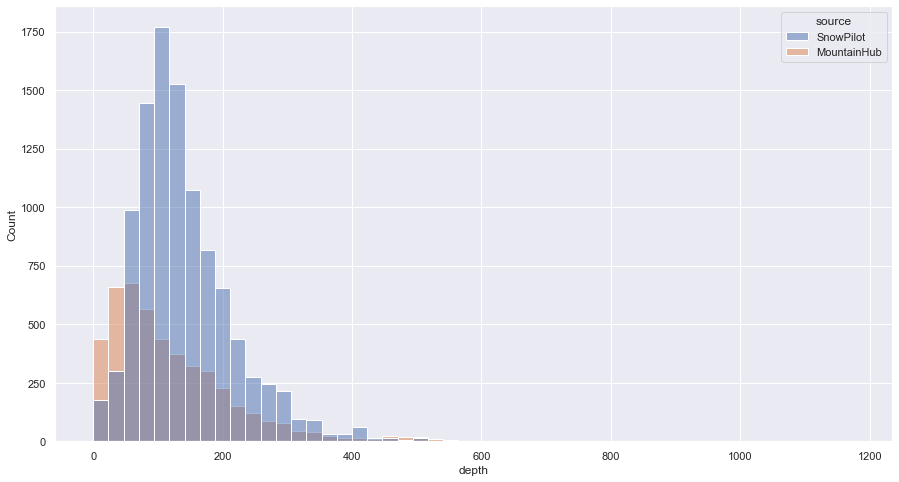

In [25]:
CSO_plots = CSO_df
sns.set(rc={'figure.figsize':(15,8)})
sns.histplot(data=CSO_df, x="depth", hue="source", bins = 50)

<AxesSubplot:xlabel='depth', ylabel='Count'>

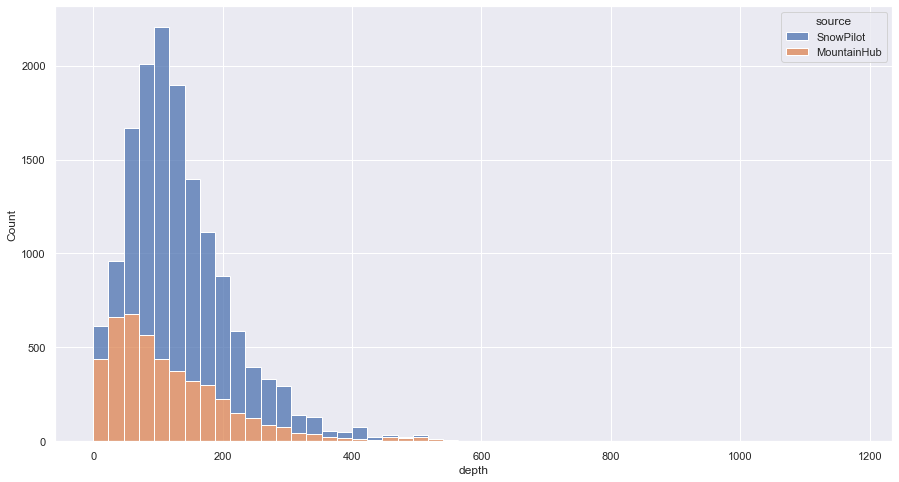

In [26]:
sns.histplot(data=CSO_df, x="depth", hue="source", multiple='stack', bins = 50)